# IMPORTS

In [1]:
# Default imports
import os

# Third party libraries
import pandas as ps
import numpy as np
import setuptools.dist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adagrad
from kerastuner.tuners import Hyperband
import keras


C:\Users\damla\AppData\Local\Temp\ipykernel_36516\1338529229.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# LOAD DATASET

In [3]:
# CONSTANTS
# 0: 5 years dataset
# 1: 10 years dataset
DATA_SET_TO_LOAD = 0

# Defining the paths to the datasets
five_dataset_path = r'./data/raw/5_years.csv'
ten_dataset_path = r'./data/raw/10_years.csv'

# Defining the path to the dataset to be used
active_dataset_path = five_dataset_path if DATA_SET_TO_LOAD == 0 else ten_dataset_path

In [4]:
# Load the dataset
dataset = ps.read_csv(active_dataset_path, parse_dates=['Date'], index_col='Date')
print(dataset.head())

                Close       Open       High        Low  Adj Close     Volume
Date                                                                        
2019-01-02  39.480000  38.722500  39.712502  38.557499  37.845047  148158800
2019-01-03  35.547501  35.994999  36.430000  35.500000  34.075390  365248800
2019-01-04  37.064999  36.132500  37.137501  35.950001  35.530052  234428400
2019-01-07  36.982498  37.174999  37.207500  36.474998  35.450966  219111200
2019-01-08  37.687500  37.389999  37.955002  37.130001  36.126778  164101200


In [5]:
# Check for missing values
print(dataset.isnull().sum())

# Check for duplicates
print(dataset.duplicated().sum())

Close        0
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64
0


# NORMALIZE DATA

In [6]:
# Normalize the dataset
def normalize_features(df):
    '''
    Normalizes the data in the dataframe
    '''
    cols = df.columns.drop('Close')
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    
    return df, scaler


def normalize_target(df):
    '''
    Normalizes the data in the dataframe
    '''
    cols = ['Close']
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(df[cols])
    
    return df, scaler
    

# PREPARE AND LOAD DATA


In [7]:
def prepare_data(df, target_col, time_steps=60):
    '''
    Prepares the data for training the LSTM model
    '''
    
    x, y = [], []
    for i in range(len(df) - time_steps):
        x.append(df[i:i + time_steps])
        y.append(df[i + time_steps, target_col])
    return np.array(x), np.array(y)

In [8]:
def preprocess_data(df, method='f_fill', drop = False, constant_fill=0.0):
    '''
    Preprocesses the data for training the LSTM model
    '''
    
    # Handle missing values
    if method == 'f_fill':
        df.fillna(method='ffill', inplace=True)    
    elif method == 'b_fill':
        df.fillna(method='bfill', inplace=True)
    elif method == 'constant':
        df.fillna(constant_fill, inplace=True)

    # Drop missing values
    if drop:
        df.dropna(inplace=True)

    # Check for missing values
    print(df.isnull().sum())
    return df 

In [9]:
TIME_STEPS = 60

df = preprocess_data(dataset, 'b_fill', drop=True)
df_features, feature_scaler = normalize_features(df)
df_target, target_scaler = normalize_target(df)

# Prepare the data 
x,y = prepare_data(df_features.values, df_target.columns.get_loc('Close'), TIME_STEPS)

# Create the training and testing and validation datasets (80% train, 10% test, 10% validation)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

# Print the shapes of the datasets
print(x_train.shape, x_test.shape, x_val.shape)


Close        0
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64
(958, 60, 6) (120, 60, 6) (120, 60, 6)


C:\Users\damla\AppData\Local\Temp\ipykernel_36516\3023603184.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


# Hardcoded Model

Epoch 1/40
84/84 [==============================] - 6s 17ms/step - loss: 0.0139 - val_loss: 0.0025
Epoch 2/40
84/84 [==============================] - 1s 9ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 3/40
84/84 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 4/40
84/84 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 5/40
84/84 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 6/40
84/84 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 7/40
84/84 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 7: early stopping
4/4 [==============================] - 0s 4ms/step


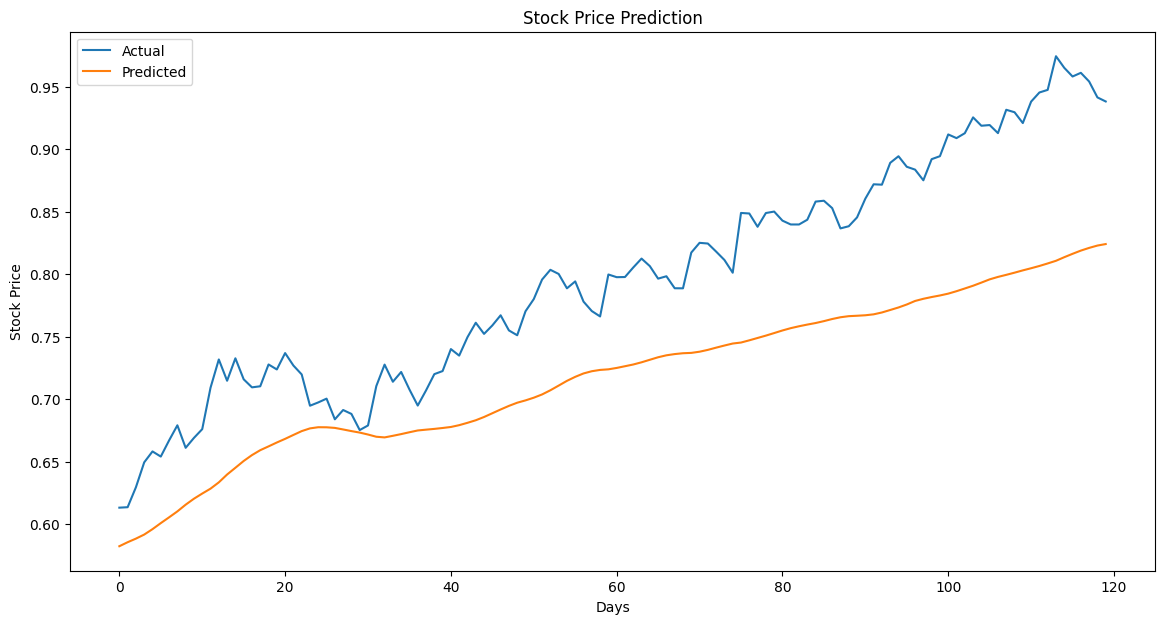

In [10]:
import matplotlib.pyplot as plt

regressor_1 = Sequential()
regressor_1.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor_1.add(Dropout(0.2))
regressor_1.add(LSTM(units=16, return_sequences=False))
regressor_1.add(Dropout(0.2))
regressor_1.add(Dense(units=1, activation='linear'))
regressor_1.compile(optimizer='adam', loss='mse')

es_1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

regressor_1.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=8, callbacks=[es_1])
pred_1 = regressor_1.predict(x_test)
pred_1.shape


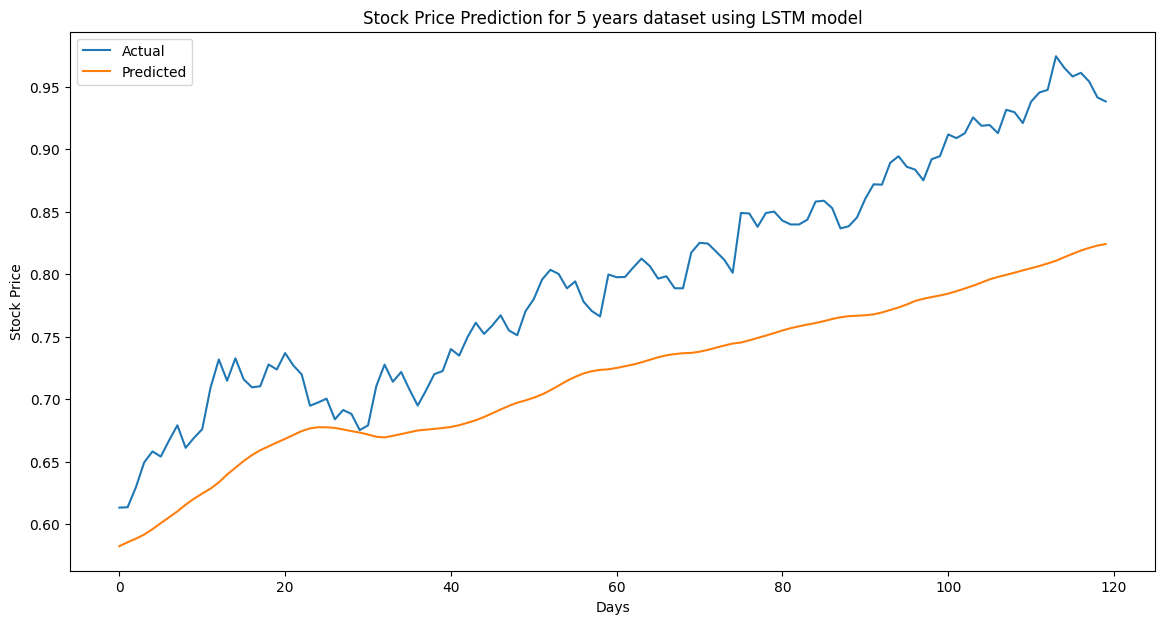

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(pred_1, label='Predicted')
plt.title('Stock Price Prediction for 5 years dataset using LSTM model')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [17]:
regressor_1.save('5year/hardcoded_model')

INFO:tensorflow:Assets written to: 5year/hardcoded_model\assets


INFO:tensorflow:Assets written to: 5year/hardcoded_model\assets


In [12]:
def get_mae_mse_mape(y_true, y_pred):
    '''
    Returns the Mean Absolute Error, Mean Squared Error, and Mean Absolute Percentage Error
    '''
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape

mae, mse, mape = get_mae_mse_mape(y_test, pred_1)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

pred_2 = regressor_1.predict(x_val)
mae, mse, mape = get_mae_mse_mape(y_val, pred_2)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

Mean Absolute Error: 0.10850428377041463
Mean Squared Error: 0.01812582186919579
Mean Absolute Percentage Error: 13.086646614780156
4/4 [==============================] - 0s 13ms/step
Mean Absolute Error: 0.10616242532603495
Mean Squared Error: 0.014542824155587096
Mean Absolute Percentage Error: 11.357539267355508


In [14]:
# https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203
def create_model(hyperparameters):
    '''
    Creates the LSTM model
     n_layers = 2, n_nodes = 50, dropout = 0.2, dense_nodes = 25, learning_rate = 0.001, loss = 'mean_squared_error'
    
    args:
        input_shape: the shape of the input data
        n_layers: the number of LSTM layers
        n_nodes: the number of nodes in each LSTM layer
        dropout: the dropout rate
        loss: the loss function
        optimizer: the optimizer
        dense_nodes: the number of nodes in the dense layer
    '''

    input_shape = (x_train.shape[1], x_train.shape[2])
    
    # Initialize a sequential model, which is a linear stack of layers
    model = Sequential()
    # Add input layer
    model.add(Input(shape=input_shape))
    # Add the first LSTM layer, which is a recurrent layer that has memoryw
    hp_units1 = hyperparameters.Int('units1', min_value=16, max_value=512, step=32)
    model.add(LSTM(units=hp_units1, return_sequences=True))
    # Add a dropout layer to prevent overfitting. This layer will randomly set 20% of the input units to 0 at each update during training time
    hp_dropout1 = hyperparameters.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout1))
    hp_layers = hyperparameters.Int('layers', min_value=1, max_value=3, step=1)
    hp_units2 = hyperparameters.Int('units2', min_value=16, max_value=512, step=16)
    # Add the remaining LSTM layers
    for i in range(hp_layers - 1):
        model.add(LSTM(hp_units2, return_sequences=True))
        model.add(Dropout(hp_dropout1))
    
    # Add a intermediate dense layer
    hp_dense_nodes = hyperparameters.Int('dense_nodes', min_value=1, max_value=64, step=16)
    model.add(Dense(hp_units1))
    
    # Compile the model
    model.compile(loss="mse", optimizer='adam', metrics=['mse'])
    
    # Return the model
    return model

In [15]:
tuner = Hyperband(
    create_model,
    objective='mean_squared_error',
    max_epochs=100,
    directory='test-2/hyperband',
    project_name='stock_price_prediction')

In [16]:
tuner.search(x_train, y_train, epochs=40, validation_data=(x_val, y_val))
best_models = tuner.get_best_models(num_models=1)

Trial 2 Complete [00h 00m 04s]

Best mean_squared_error So Far: None
Total elapsed time: 00h 00m 06s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |48                |units1
0.1               |0.4               |dropout1
3                 |1                 |layers
32                |32                |units2
1                 |1                 |dense_nodes
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
27/30 [==========================>...] - ETA: 0s - loss: 0.2163 - mse: 0.2163

Traceback (most recent call last):
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\tensorflow\python\eager\execute.py", line 54, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node 'mean_squared_error/SquaredDifference' defined at (most recent call last):
    File "c:\Users\damla\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\damla\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\damla\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\damla\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\damla\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\damla\AppData\Local\Temp\ipykernel_36516\1192037335.py", line 1, in <module>
      tuner.search(x_train, y_train, epochs=40, validation_data=(x_val, y_val))
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 234, in search
      self._try_run_and_update_trial(trial, *fit_args, **fit_kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
      self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
      results = self.run_trial(trial, *fit_args, **fit_kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\tuners\hyperband.py", line 427, in run_trial
      return super().run_trial(trial, *fit_args, **fit_kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
      obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
      results = self.hypermodel.fit(hp, model, *args, **kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
      return model.fit(*args, **kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\damla\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
      return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
Node: 'mean_squared_error/SquaredDifference'
required broadcastable shapes
	 [[{{node mean_squared_error/SquaredDifference}}]] [Op:__inference_train_function_30126]


In [26]:
best_models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            19968     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 288)           406656    
                                                                 
 dropout_1 (Dropout)         (None, 60, 288)           0         
                                                                 
 dense (Dense)               (None, 60, 64)            18496     
                                                                 
 batch_normalization (BatchN  (None, 60, 64)           256       
 ormalization)                                                   
                                                        

In [59]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

model = tuner.hypermodel.build(best_hyperparameters)
fitted_model = model.fit(x_train, y_train, epochs=1000, validation_data=(x_val, y_val), batch_size=64, shuffle=False)#, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)])

model.save(f'5year/model')

{'units1': 64, 'dropout1': 0.2, 'layers': 2, 'units2': 288, 'learning_rate': 0.01, 'tuner/epochs': 34, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Epoch 1/1000
15/15 [==============================] - 2s 47ms/step - loss: 3.7572 - mean_squared_error: 3.7572 - val_loss: 11.2806 - val_mean_squared_error: 11.2806
Epoch 2/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 7.4025 - val_mean_squared_error: 7.4025
Epoch 3/1000
15/15 [==============================] - 0s 13ms/step - loss: 0.0801 - mean_squared_error: 0.0801 - val_loss: 2.7362 - val_mean_squared_error: 2.7362
Epoch 4/1000
15/15 [==============================] - 0s 13ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 1.2803 - val_mean_squared_error: 1.2803
Epoch 5/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0866 - mean_squared_error: 0.0866 - val_loss: 1.0952 - val_mean_squared_error: 1.0952
Epoch 6/1000
15/

INFO:tensorflow:Assets written to: 5year/model\assets


INFO:tensorflow:Assets written to: 5year/model\assets


In [60]:
# evaluate the model
train_loss = model.evaluate(x_train, y_train, verbose=0)
val_loss = model.evaluate(x_val, y_val, verbose=0)

print('Train loss:', train_loss)
print('Validation loss:', val_loss)

Train loss: [0.06286703050136566, 0.06286704540252686]
Validation loss: [0.16628125309944153, 0.16628125309944153]


4/4 [==============================] - 0s 21ms/step
(120,)
Mean Squared Error: 2423.922722295336
Mean Absolute Error: 46.96106445367136
Mean Absolute Percentage Error: 0.27897091128564633


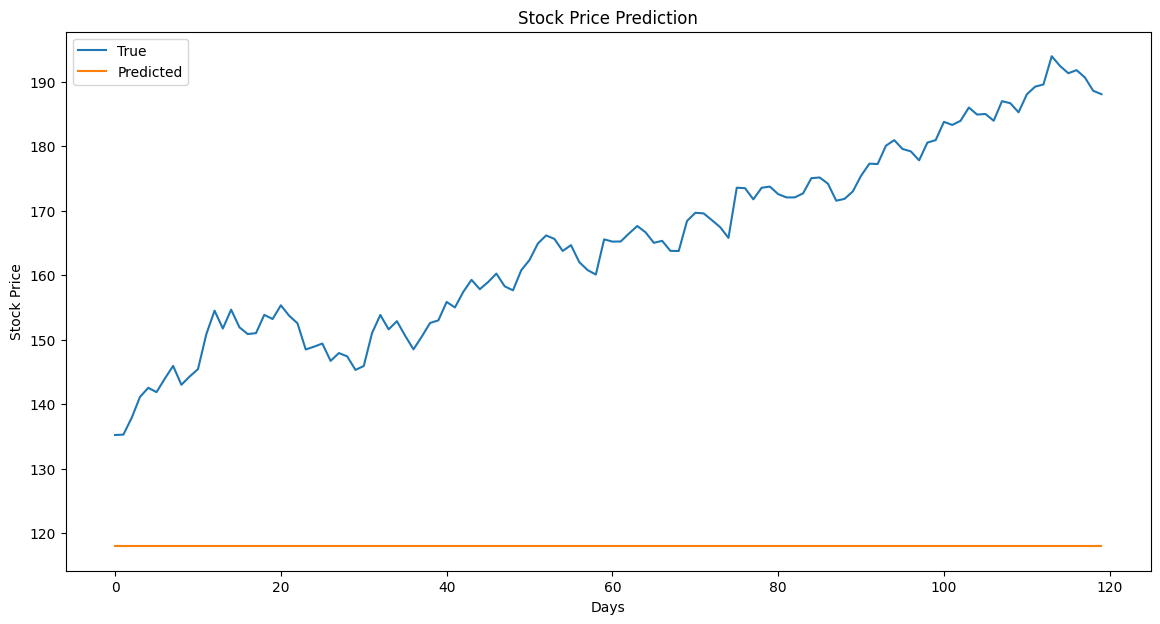

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


# predict the future stock prices
predictions = model.predict(x_test)

# preprocess the predictions
pred = []
for i in range(len(predictions)):
    pred.append(predictions[i][0].item())
pred = np.array(pred)

print(pred.shape)

# inverse the normalization
predictions_reshaped = pred.reshape(-1, 1)
predictions_inversed = target_scaler.inverse_transform(predictions_reshaped) # gives ValueError: Found array with dim 3. None expected <= 2.
y_test_reshaped = y_test.reshape(-1, 1)
y_test_inversed = target_scaler.inverse_transform(y_test_reshaped)

mse_model = mean_squared_error(y_test_inversed, predictions_inversed)
mae_model = mean_absolute_error(y_test_inversed, predictions_inversed)
mape_model = mean_absolute_percentage_error(y_test_inversed, predictions_inversed)

print('Mean Squared Error:', mse_model)
print('Mean Absolute Error:', mae_model)
print('Mean Absolute Percentage Error:', mape_model)


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(y_test_inversed, label='True')
plt.plot(predictions_inversed, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [62]:
print("True Mean ", y_test_inversed.mean())
print("True Std  ", y_test_inversed.std())

print("Pred Mean ", predictions_inversed.mean())
print("Pred Std  ", predictions_inversed.std())

True Mean  164.9175833384196
True Std   14.78449010529143
Pred Mean  117.95651888474823
Pred Std   0.0
